# Script Set Up

In [1]:
%matplotlib inline

In [2]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 29.2 MB/s eta 0:00:00


In [3]:
!pip install pingouin
import pingouin as pg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=96026c8bc2cc8065ab7f978e91e8cd48815f718d668ba3a1ab16787cb2dc356b
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [4]:
!pip install dataframe-image
import dataframe_image as dfi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.5/398.5 kB 11.0 MB/s eta 0:00:00


In [5]:
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns
import mne

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Deciding what response times are outliers that should be removed

In [7]:
lower_RT_cutoff = 150
upper_RT_cutoff = 1500 # 1.5x longest SI and is less than 1% of trials

# Load Epochs
Load each participant's epochs

In [8]:
ID_list = ['P1', 'P3', 'P4', 'P7', 'P10', 'P12', 'P15', 'P17', 'P19', 'P21', 'P22', 'P23', 'P24',
           'P26', 'P27', 'P28', 'P29', 'P30']

n_participants = len(ID_list)
n_channels_evoked = 128
n_channels_epochs = 145
n_times_encode = 717
n_times_repo = 616
n_times_RL = 615

sample_rate = 512

encode_epochs = []
encode_metadata = []
repo_epochs = []
repo_metadata = []
RL_epochs = []
RL_metadata = []

all_encode_evokeds = np.zeros([len(ID_list), n_channels_evoked, n_times_encode])
all_repo_evokeds = np.zeros([len(ID_list), n_channels_evoked, n_times_repo])
all_RL_evokeds = np.zeros([len(ID_list), n_channels_evoked, n_times_RL])

i = -1

for ID in ID_list:
  i += 1
  encode_fname = "/content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/" + ID + "_Encode_All_CSD_epo.fif"
  repo_fname = "/content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/" + ID + "_Reproduction_All_CSD_epo.fif"
  RL_fname = "/content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/" + ID + "_RL_All_CSD_epo.fif"

  encode_epochs_participant = mne.read_epochs(encode_fname, preload = False)
  repo_epochs_participant = mne.read_epochs(repo_fname, preload = False)
  RL_epochs_participant = mne.read_epochs(RL_fname, preload = False)

  encode_epochs_participant.load_data()
  repo_epochs_participant.load_data()
  RL_epochs_participant.load_data()

  info = encode_epochs_participant.info

  # Adding ID column to metadata 19/12/22
  encode_df = encode_epochs_participant.metadata
  encode_df["ID"] = ID # adding ID column
  temp_cols=encode_df.columns.tolist()
  new_cols=temp_cols[-1:] + temp_cols[:-1]
  encode_df=encode_df[new_cols]
  encode_metadata.append(encode_df)

  repo_df = repo_epochs_participant.metadata
  repo_df["ID"] = ID # adding ID column
  temp_cols=repo_df.columns.tolist()
  new_cols=temp_cols[-1:] + temp_cols[:-1]
  repo_df=repo_df[new_cols]
  repo_metadata.append(repo_df)

  RL_df = RL_epochs_participant.metadata
  RL_df["ID"] = ID # adding ID column
  temp_cols=RL_df.columns.tolist()
  new_cols=temp_cols[-1:] + temp_cols[:-1]
  RL_df=RL_df[new_cols]
  RL_metadata.append(RL_df)

  ## Evoked ##
  all_encode_evokeds[i] = encode_epochs_participant.average().data
  all_repo_evokeds[i] = repo_epochs_participant.average().data
  all_RL_evokeds[i] = RL_epochs_participant.average().data

Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P1_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
775 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P1_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
762 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P1_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
762 matching events found
No baseline correction applied
0 proje

# Concatenate Metadata
Concatenate metadata so that all participants epochs are in one array


In [9]:
encode_metadata = pd.concat(encode_metadata, ignore_index = True)
encode_metadata

,ID,trial_number,Response_Time,Over_Under,Mean_RT,Median_RT,Trigger,Gap,Reject_Artif,RT_gap,Reject_All
0,P1,0,851.562500,0.0,1026.308594,1013.867188,56,431.640625,0.0,1283.203125,0.0
1,P1,1,865.234375,0.0,997.128906,981.640625,53,402.343750,0.0,1267.578125,1.0
2,P1,3,861.328125,0.0,1038.046875,1029.492188,58,373.046875,0.0,1234.375000,1.0
3,P1,4,914.062500,0.0,1013.515625,1011.914062,55,437.500000,0.0,1351.562500,0.0
4,P1,5,880.859375,0.0,945.742188,942.578125,51,437.500000,0.0,1318.359375,0.0
...,...,...,...,...,...,...,...,...,...,...,...
13607,P30,894,1197.265625,1.0,1159.707031,1137.890625,59,402.343750,0.0,1599.609375,0.0
13608,P30,895,923.828125,1.0,884.492188,860.546875,51,443.359375,0.0,1367.187500,0.0
13609,P30,896,912.109375,1.0,892.343750,874.218750,52,355.468750,0.0,1267.578125,0.0
13610,P30,897,1107.421875,1.0,1109.980469,1095.898438,58,443.359375,0.0,1550.781250,0.0


In [10]:
repo_metadata = pd.concat(repo_metadata, ignore_index = True)
repo_metadata

,ID,trial_number,Response_Time,Over_Under,Mean_RT,Median_RT,Trigger,Gap,Reject_Artif,RT_gap,Reject_All
0,P1,0,851.562500,0.0,1026.308594,1013.867188,156,431.640625,0.0,1283.203125,0.0
1,P1,4,914.062500,0.0,1013.515625,1011.914062,155,437.500000,0.0,1351.562500,0.0
2,P1,5,880.859375,0.0,945.742188,942.578125,151,437.500000,0.0,1318.359375,0.0
3,P1,6,742.187500,0.0,980.234375,965.039062,152,390.625000,0.0,1132.812500,0.0
4,P1,10,832.031250,0.0,980.234375,965.039062,152,417.968750,0.0,1250.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
13152,P30,894,1197.265625,1.0,1159.707031,1137.890625,159,402.343750,0.0,1599.609375,0.0
13153,P30,895,923.828125,1.0,884.492188,860.546875,151,443.359375,0.0,1367.187500,0.0
13154,P30,896,912.109375,1.0,892.343750,874.218750,152,355.468750,0.0,1267.578125,0.0
13155,P30,897,1107.421875,1.0,1109.980469,1095.898438,158,443.359375,0.0,1550.781250,0.0


In [11]:
RL_metadata = pd.concat(RL_metadata, ignore_index = True)
RL_metadata

,ID,trial_number,Response_Time,Over_Under,Mean_RT,Median_RT,Trigger,Gap,Reject_Artif,RT_gap,Reject_All
0,P1,0,851.562500,0.0,1026.308594,1013.867188,206,431.640625,0.0,1283.203125,0.0
1,P1,4,914.062500,0.0,1013.515625,1011.914062,205,437.500000,0.0,1351.562500,0.0
2,P1,5,880.859375,0.0,945.742188,942.578125,201,437.500000,0.0,1318.359375,0.0
3,P1,6,742.187500,0.0,980.234375,965.039062,202,390.625000,0.0,1132.812500,0.0
4,P1,10,832.031250,0.0,980.234375,965.039062,202,417.968750,0.0,1250.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
13114,P30,894,1197.265625,1.0,1159.707031,1137.890625,209,402.343750,0.0,1599.609375,0.0
13115,P30,895,923.828125,1.0,884.492188,860.546875,201,443.359375,0.0,1367.187500,0.0
13116,P30,896,912.109375,1.0,892.343750,874.218750,202,355.468750,0.0,1267.578125,0.0
13117,P30,897,1107.421875,1.0,1109.980469,1095.898438,208,443.359375,0.0,1550.781250,0.0


# Defining X-axis and Color Palette for Plots
For the waveform plots, there is 1 data point for each time point (i.e each sample), so the x-axis corresponds to the number of time points in an epoch

In [12]:
from matplotlib import pyplot as plt

In [13]:
encode_times_for_plot = (np.arange(0, n_times_encode) / 512 * 1000) - 200
repo_times_for_plot = (np.arange(0, n_times_repo) / 512 * 1000) - 300
RL_times_for_plot = (np.arange(0, n_times_RL) / 512 * 1000) - 1100

# Define Time Windows for Calculations


In [14]:
# For checking amplitude at target offset
encode_amplitude_window_start = -50
encode_amplitude_window_end = +50 # these have to be done within sample interval bin

# For checking the amplitude at cue onset
repo_amplitude_window_start = -50
repo_amplitude_window_start_idx = int(np.argwhere(repo_times_for_plot >= repo_amplitude_window_start)[0])
repo_amplitude_window_end = +50
repo_amplitude_window_end_idx = int(np.argwhere(repo_times_for_plot >= repo_amplitude_window_end)[0])

# For checking build-up rate in anticipation of response
RL_slope_window_start = -600
RL_slope_window_start_idx = int(np.argwhere(RL_times_for_plot >= RL_slope_window_start)[0])
RL_slope_window_end = -300
RL_slope_window_end_idx = int(np.argwhere(RL_times_for_plot >= RL_slope_window_end)[0])

# For checking amp of pre-response CNV
RL_amp_window_start = -100
RL_amp_window_start_idx = int(np.argwhere(RL_times_for_plot >= RL_amp_window_start)[0])
RL_amp_window_end = -50
RL_amp_window_end_idx = int(np.argwhere(RL_times_for_plot >= RL_amp_window_end)[0])

# For checking build-up rate of CPP in anticipation of response
RL_CPP_window_start = -600
RL_CPP_window_start_idx = int(np.argwhere(RL_times_for_plot >= RL_CPP_window_start)[0])
RL_CPP_window_end = -300
RL_CPP_window_end_idx = int(np.argwhere(RL_times_for_plot >= RL_CPP_window_end)[0])

# Plotting Grand Average

## Average Across Participants and Convert into MNE Object

In [15]:
group_encode_evoked_data = np.mean(all_encode_evokeds, axis = 0)
group_repo_evoked_data = np.mean(all_repo_evokeds, axis = 0)
group_RL_evoked_data = np.mean(all_RL_evokeds, axis = 0)

print(group_encode_evoked_data.shape)
print(group_repo_evoked_data.shape)
print(group_RL_evoked_data.shape)

group_encode_evoked = mne.EvokedArray(group_encode_evoked_data, info = info, tmin = -0.2, nave = len(ID_list))
group_repo_evoked = mne.EvokedArray(group_repo_evoked_data, info = info, tmin = -0.1, nave = len(ID_list))
group_RL_evoked = mne.EvokedArray(group_RL_evoked_data, info = info, tmin = -1.1, nave = len(ID_list))

print(group_encode_evoked)
print(group_repo_evoked)
print(group_RL_evoked)

(128, 717)
(128, 616)
(128, 615)
<Evoked | '' (average, N=18), -0.19922 – 1.1992 s, baseline off, 128 ch, ~897 kB>
<Evoked | '' (average, N=18), -0.099609 – 1.1016 s, baseline off, 128 ch, ~796 kB>
<Evoked | '' (average, N=18), -1.0996 – 0.099609 s, baseline off, 128 ch, ~795 kB>


In [16]:
CPP_electrodes = ["A4", "A19"]
CNV_electrodes = ["C23", "C22"]

In [17]:
CNV_idx = []
for ch in CNV_electrodes:
  CNV_idx.append(group_encode_evoked.ch_names.index(ch))
print(CNV_idx)

CPP_idx = []
for ch in CPP_electrodes:
  CPP_idx.append(group_encode_evoked.ch_names.index(ch))
print(CPP_idx)

[86, 85]
[3, 18]


# Calculating Single Trial Measurements

## Doing Calculation

In [18]:
m_idx_encode = -1
m_idx_repo = -1
m_idx_RL = -1

for i in range(0, len(ID_list)):
  ## Loading in epochs and removing outliers
  ID = ID_list[i]
  encode_fname = "/content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/" + ID + "_Encode_All_CSD_epo.fif"
  repo_fname = "/content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/" + ID + "_Reproduction_All_CSD_epo.fif"
  RL_fname = "/content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/" + ID + "_RL_All_CSD_epo.fif"

  encode_epochs_participant = mne.read_epochs(encode_fname, preload = False)
  repo_epochs_participant = mne.read_epochs(repo_fname, preload = False)
  RL_epochs_participant = mne.read_epochs(RL_fname, preload = False)

  encode_epochs_participant.load_data()
  repo_epochs_participant.load_data()
  RL_epochs_participant.load_data()

  info = encode_epochs_participant.info

  ## Iterating through each trial for each epoch and doing the calculation ##

  ## Encode Epoch
  encode_epochs_participant_data = encode_epochs_participant.get_data()
  for e in range(0, encode_epochs_participant_data.shape[0]):
    m_idx_encode += 1 # index we are using for adding these measures to the metadata
    this_trial = encode_epochs_participant_data[e] # get data for this trial
    CNV_electrodes_this_trial = np.mean(this_trial[CNV_idx], axis = 0) # average across chosen electrodes
    CPP_electrodes_this_trial = np.mean(this_trial[CPP_idx], axis = 0)

    SI = 0 ## doing calculation
    if encode_metadata.at[m_idx_encode, "Trigger"] == 51:
      SI = 600
    elif encode_metadata.at[m_idx_encode, "Trigger"] == 52:
      SI = 650
    elif encode_metadata.at[m_idx_encode, "Trigger"] == 53:
      SI = 700
    elif encode_metadata.at[m_idx_encode, "Trigger"] == 54:
      SI = 750
    elif encode_metadata.at[m_idx_encode, "Trigger"] == 55:
      SI = 800
    elif encode_metadata.at[m_idx_encode, "Trigger"] == 56:
      SI = 850
    elif encode_metadata.at[m_idx_encode, "Trigger"] == 57:
      SI = 900
    elif encode_metadata.at[m_idx_encode, "Trigger"] == 58:
      SI = 950
    elif encode_metadata.at[m_idx_encode, "Trigger"] == 59:
      SI = 1000
    low_cutoff = SI + (encode_amplitude_window_start)
    high_cutoff = SI + (encode_amplitude_window_end)
    encode_window_start_idx = int(np.argwhere(encode_times_for_plot >= low_cutoff)[0])
    encode_window_end_idx = int(np.argwhere(encode_times_for_plot >= high_cutoff)[0])
    encode_metadata.at[m_idx_encode, "Encode_Offset_CNV_Amp"] = np.mean(CNV_electrodes_this_trial[encode_window_start_idx:encode_window_end_idx] * 1e6, axis = 0)
    encode_metadata.at[m_idx_encode, "Encode_Offset_CPP_Amp"] = np.mean(CPP_electrodes_this_trial[encode_window_start_idx:encode_window_end_idx] * 1e6, axis = 0)

    x = encode_times_for_plot[encode_window_start_idx:encode_window_end_idx] # get times for each window as the x-axis
    result = stats.linregress(x,  CNV_electrodes_this_trial[encode_window_start_idx:encode_window_end_idx] * 1e6)
    encode_metadata.at[m_idx_encode, "Encode_Offset_CNV_Slope"] = result.slope
    x = encode_times_for_plot[encode_window_start_idx:encode_window_end_idx] # get times for each window as the x-axis
    result = stats.linregress(x,  CPP_electrodes_this_trial[encode_window_start_idx:encode_window_end_idx] * 1e6)
    encode_metadata.at[m_idx_encode, "Encode_Offset_CPP_Slope"] = result.slope

  ## Repo Epoch
  repo_epochs_participant_data = repo_epochs_participant.get_data()
  for e in range(0, repo_epochs_participant_data.shape[0]):
    m_idx_repo += 1 # index we are using for adding these measures to the metadata
    this_trial = repo_epochs_participant_data[e] # get data for this trial
    CNV_electrodes_this_trial = np.mean(this_trial[CNV_idx], axis = 0) # average across chosen electrodes
    CNV_electrodes_this_trial = CNV_electrodes_this_trial * 1e6
    repo_metadata.at[m_idx_repo, "Repo_Onset_CNV_Amp"] = np.mean(CNV_electrodes_this_trial[repo_amplitude_window_start_idx:repo_amplitude_window_end_idx], axis = 0)

    CPP_electrodes_this_trial = np.mean(this_trial[CPP_idx], axis = 0) # average across chosen electrodes
    CPP_electrodes_this_trial = CPP_electrodes_this_trial * 1e6
    repo_metadata.at[m_idx_repo, "Repo_Onset_CPP_Amp"] = np.mean(CPP_electrodes_this_trial[repo_amplitude_window_start_idx:repo_amplitude_window_end_idx], axis = 0)

  ## RL Epoch
  RL_epochs_participant_data = RL_epochs_participant.get_data()
  for e in range(0, RL_epochs_participant_data.shape[0]):
    m_idx_RL += 1 # index we are using for adding these measures to the metadata
    this_trial = RL_epochs_participant_data[e] # get data for this trial
    CNV_electrodes_this_trial = np.mean(this_trial[CNV_idx], axis = 0) # average across chosen electrodes
    CPP_electrodes_this_trial = np.mean(this_trial[CPP_idx], axis = 0)
    CNV_electrodes_this_trial = CNV_electrodes_this_trial * 1e6
    CPP_electrodes_this_trial = CPP_electrodes_this_trial * 1e6

    # Calculate amplitude
    CNV_electrodes_this_trial = CNV_electrodes_this_trial[RL_amp_window_start_idx: RL_amp_window_end_idx]
    RL_metadata.at[m_idx_RL, "RL_CNV_Amp"] = np.mean(CNV_electrodes_this_trial, axis = 0)

    CPP_electrodes_this_trial = CPP_electrodes_this_trial[RL_CPP_window_start_idx: RL_CPP_window_end_idx]
    RL_metadata.at[m_idx_RL, "RL_CPP_Amp"] = np.mean(CPP_electrodes_this_trial, axis = 0)

    # Calculate slope
    this_trial = RL_epochs_participant_data[e] # get data for this trial
    CNV_electrodes_this_trial = np.mean(this_trial[CNV_idx], axis = 0) # average across chosen electrodes
    CPP_electrodes_this_trial = np.mean(this_trial[CPP_idx], axis = 0)
    CNV_electrodes_this_trial = CNV_electrodes_this_trial * 1e6
    CPP_electrodes_this_trial = CPP_electrodes_this_trial * 1e6
    CNV_electrodes_this_trial = CNV_electrodes_this_trial[RL_slope_window_start_idx: RL_slope_window_end_idx] # get signal in each window as the y-axis
    CPP_electrodes_this_trial = CPP_electrodes_this_trial[RL_CPP_window_start_idx: RL_CPP_window_end_idx]
    x = RL_times_for_plot[RL_slope_window_start_idx: RL_slope_window_end_idx] # get times for each window as the x-axis
    result = stats.linregress(x,  CNV_electrodes_this_trial)
    RL_metadata.at[m_idx_RL, "RL_CNV_Slope"] = result.slope
    x = RL_times_for_plot[RL_CPP_window_start_idx: RL_CPP_window_end_idx] # get times for each window as the x-axis
    result = stats.linregress(x,  CPP_electrodes_this_trial)
    RL_metadata.at[m_idx_RL, "RL_CPP_Slope"] = result.slope

Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P1_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
775 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P1_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
762 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P1_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
762 matching events found
No baseline correction applied
0 proje

<ipython-input-18-17b2f7ec86fc>:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  encode_epochs_participant_data = encode_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  repo_epochs_participant_data = repo_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:79: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  RL_epochs_participant_data = RL_epochs_participant.get_data()


Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P3_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
657 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P3_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
582 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P3_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
581 matching events found
No baseline correction applied
0 proje

<ipython-input-18-17b2f7ec86fc>:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  encode_epochs_participant_data = encode_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  repo_epochs_participant_data = repo_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:79: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  RL_epochs_participant_data = RL_epochs_participant.get_data()


Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P4_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
696 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P4_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
726 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P4_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
738 matching events found
No baseline correction applied
0 proje

<ipython-input-18-17b2f7ec86fc>:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  encode_epochs_participant_data = encode_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  repo_epochs_participant_data = repo_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:79: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  RL_epochs_participant_data = RL_epochs_participant.get_data()


Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P7_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
574 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P7_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
623 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P7_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
665 matching events found
No baseline correction applied
0 proje

<ipython-input-18-17b2f7ec86fc>:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  encode_epochs_participant_data = encode_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  repo_epochs_participant_data = repo_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:79: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  RL_epochs_participant_data = RL_epochs_participant.get_data()


Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P10_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
796 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P10_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
660 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P10_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
630 matching events found
No baseline correction applied
0 pr

<ipython-input-18-17b2f7ec86fc>:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  encode_epochs_participant_data = encode_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  repo_epochs_participant_data = repo_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:79: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  RL_epochs_participant_data = RL_epochs_participant.get_data()


Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P12_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
736 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P12_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
674 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P12_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
669 matching events found
No baseline correction applied
0 pr

<ipython-input-18-17b2f7ec86fc>:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  encode_epochs_participant_data = encode_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  repo_epochs_participant_data = repo_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:79: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  RL_epochs_participant_data = RL_epochs_participant.get_data()


Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P15_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
640 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P15_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
591 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P15_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
597 matching events found
No baseline correction applied
0 pr

<ipython-input-18-17b2f7ec86fc>:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  encode_epochs_participant_data = encode_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  repo_epochs_participant_data = repo_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:79: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  RL_epochs_participant_data = RL_epochs_participant.get_data()


Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P17_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
751 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P17_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
741 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P17_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
735 matching events found
No baseline correction applied
0 pr

<ipython-input-18-17b2f7ec86fc>:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  encode_epochs_participant_data = encode_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  repo_epochs_participant_data = repo_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:79: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  RL_epochs_participant_data = RL_epochs_participant.get_data()


Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P19_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
685 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P19_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
625 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P19_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
620 matching events found
No baseline correction applied
0 pr

<ipython-input-18-17b2f7ec86fc>:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  encode_epochs_participant_data = encode_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  repo_epochs_participant_data = repo_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:79: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  RL_epochs_participant_data = RL_epochs_participant.get_data()


Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P21_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
853 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P21_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
874 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P21_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
869 matching events found
No baseline correction applied
0 pr

<ipython-input-18-17b2f7ec86fc>:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  encode_epochs_participant_data = encode_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  repo_epochs_participant_data = repo_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:79: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  RL_epochs_participant_data = RL_epochs_participant.get_data()


Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P22_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
780 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P22_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
736 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P22_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
737 matching events found
No baseline correction applied
0 pr

<ipython-input-18-17b2f7ec86fc>:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  encode_epochs_participant_data = encode_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  repo_epochs_participant_data = repo_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:79: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  RL_epochs_participant_data = RL_epochs_participant.get_data()


Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P23_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
774 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P23_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
767 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P23_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
764 matching events found
No baseline correction applied
0 pr

<ipython-input-18-17b2f7ec86fc>:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  encode_epochs_participant_data = encode_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  repo_epochs_participant_data = repo_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:79: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  RL_epochs_participant_data = RL_epochs_participant.get_data()


Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P24_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
736 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P24_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
656 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P24_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
633 matching events found
No baseline correction applied
0 pr

<ipython-input-18-17b2f7ec86fc>:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  encode_epochs_participant_data = encode_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  repo_epochs_participant_data = repo_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:79: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  RL_epochs_participant_data = RL_epochs_participant.get_data()


Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P26_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
857 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P26_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
855 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P26_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
848 matching events found
No baseline correction applied
0 pr

<ipython-input-18-17b2f7ec86fc>:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  encode_epochs_participant_data = encode_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  repo_epochs_participant_data = repo_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:79: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  RL_epochs_participant_data = RL_epochs_participant.get_data()


Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P27_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
862 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P27_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
830 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P27_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
831 matching events found
No baseline correction applied
0 pr

<ipython-input-18-17b2f7ec86fc>:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  encode_epochs_participant_data = encode_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  repo_epochs_participant_data = repo_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:79: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  RL_epochs_participant_data = RL_epochs_participant.get_data()


Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P28_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
682 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P28_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
712 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P28_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
704 matching events found
No baseline correction applied
0 pr

<ipython-input-18-17b2f7ec86fc>:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  encode_epochs_participant_data = encode_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  repo_epochs_participant_data = repo_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:79: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  RL_epochs_participant_data = RL_epochs_participant.get_data()


Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P29_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
873 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P29_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
867 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P29_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
861 matching events found
No baseline correction applied
0 pr

<ipython-input-18-17b2f7ec86fc>:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  encode_epochs_participant_data = encode_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  repo_epochs_participant_data = repo_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:79: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  RL_epochs_participant_data = RL_epochs_participant.get_data()


Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P30_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
885 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P30_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
876 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P30_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
875 matching events found
No baseline correction applied
0 pr

<ipython-input-18-17b2f7ec86fc>:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  encode_epochs_participant_data = encode_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  repo_epochs_participant_data = repo_epochs_participant.get_data()
<ipython-input-18-17b2f7ec86fc>:79: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  RL_epochs_participant_data = RL_epochs_participant.get_data()


In [19]:
encode_metadata_copy = encode_metadata.copy()
repo_metadata_copy = repo_metadata.copy()
RL_metadata_copy = RL_metadata.copy()

## Removing Outlier RTs
Removing RTs < 150ms abd RTs > 1500ms

In [20]:
print(encode_metadata.shape[0])
encode_metadata_outliers = encode_metadata.query("Response_Time < 150").index
print(encode_metadata_outliers)
encode_metadata_outliers = list(encode_metadata_outliers)
print(encode_metadata_outliers)
print(len(encode_metadata_outliers))
encode_metadata_outliers += list(encode_metadata.query("Response_Time > 1500").index)
encode_metadata = encode_metadata.drop(encode_metadata_outliers)
print(encode_metadata.shape[0])

print(repo_metadata.shape[0])
repo_metadata_outliers = repo_metadata.query("Response_Time < 150").index
print(repo_metadata_outliers)
repo_metadata_outliers = list(repo_metadata_outliers)
print(repo_metadata_outliers)
print(len(repo_metadata_outliers))
repo_metadata_outliers += list(repo_metadata.query("Response_Time > 1500").index)
repo_metadata = repo_metadata.drop(repo_metadata_outliers)
print(repo_metadata.shape[0])

print(RL_metadata.shape[0])
RL_metadata_outliers = RL_metadata.query("Response_Time < 150").index
print(RL_metadata_outliers)
RL_metadata_outliers = list(RL_metadata_outliers)
print(RL_metadata_outliers)
print(len(RL_metadata_outliers))
RL_metadata_outliers += list(RL_metadata.query("Response_Time > 1500").index)
RL_metadata = RL_metadata.drop(RL_metadata_outliers)
print(RL_metadata.shape[0])

13612
Int64Index([12415], dtype='int64')
[12415]
1
13492
13157
Int64Index([11972], dtype='int64')
[11972]
1
13036
13119
Int64Index([11935], dtype='int64')
[11935]
1
12999


## Re-Label Trigger Variable as SI

In [21]:
replace_dict = {51: 600, 52: 650, 53: 700, 54: 750, 55: 800, 56: 850, 57: 900, 58: 950, 59: 1000}
encode_metadata["Trigger"].replace(replace_dict, inplace = True)
encode_metadata.rename(columns = {"Trigger": "SI"}, inplace = True)

replace_dict = {151: 600, 152: 650, 153: 700, 154: 750, 155: 800, 156: 850, 157: 900, 158: 950, 159: 1000}
repo_metadata["Trigger"].replace(replace_dict, inplace = True)
repo_metadata.rename(columns = {"Trigger": "SI"}, inplace = True)

replace_dict = {201: 600, 202: 650, 203: 700, 204: 750, 205: 800, 206: 850, 207: 900, 208: 950, 209: 1000}
RL_metadata["Trigger"].replace(replace_dict, inplace = True)
RL_metadata.rename(columns = {"Trigger": "SI"}, inplace = True)

In [22]:
SIs = np.unique(RL_metadata["SI"])

# Bin by RT via median split within participant within sample interval

In [23]:
RT_cutoffs = np.zeros((len(ID_list), len(SIs)))
repo_RT_cutoffs = np.zeros((len(ID_list), len(SIs)))
encode_RT_cutoffs = np.zeros((len(ID_list), len(SIs)))

for i in range(0, len(ID_list)): # iterate through participants
  ID = ID_list[i]
  RT_cutoff_1 = np.zeros(len(SIs))
  repo_RT_cutoff_1 = np.zeros(len(SIs))
  encode_RT_cutoff_1 = np.zeros(len(SIs))

  for j in range(0, len(SIs)): # iterate through SIs
    si = SIs[j]
    #RL_participant_df = RL_metadata.query("ID == @ID & SI == @si").copy()
    RL_participant_df = RL_metadata[(RL_metadata["ID"] == ID) & (RL_metadata["SI"] == si)].copy()
    RT_cutoffs[i, j] = RL_participant_df["Response_Time"].median()

    #repo_participant_df = repo_metadata.query("ID == @ID & SI == @si").copy()
    repo_participant_df = repo_metadata[(repo_metadata["ID"] == ID) & (repo_metadata["SI"] == si)].copy()
    repo_RT_cutoffs[i, j] = repo_participant_df["Response_Time"].median()

    #encode_participant_df = encode_metadata.query("ID == @ID & SI == @si").copy()
    encode_participant_df = encode_metadata[(encode_metadata["ID"] == ID) & (encode_metadata["SI"] == si)].copy()
    encode_RT_cutoffs[i, j] = encode_participant_df["Response_Time"].median()

In [24]:
for index in RL_metadata.index:
  ID_index = ID_list.index(RL_metadata.at[index, "ID"])
  SI_index = list(SIs).index(RL_metadata.at[index, "SI"])

  if RL_metadata.at[index, "Response_Time"] < RT_cutoffs[ID_index, SI_index]:
    RL_metadata.at[index, "RT_Bin2"] = 1
  elif RL_metadata.at[index, "Response_Time"] > RT_cutoffs[ID_index, SI_index]:
    RL_metadata.at[index, "RT_Bin2"] = 2

In [25]:
for index in repo_metadata.index:
  ID_index = ID_list.index(repo_metadata.at[index, "ID"])
  SI_index = list(SIs).index(repo_metadata.at[index, "SI"])

  if repo_metadata.at[index, "Response_Time"] < RT_cutoffs[ID_index, SI_index]:
    repo_metadata.at[index, "RT_Bin2"] = 1
  elif repo_metadata.at[index, "Response_Time"] > RT_cutoffs[ID_index, SI_index]:
    repo_metadata.at[index, "RT_Bin2"] = 2

In [26]:
for index in encode_metadata.index:
  ID_index = ID_list.index(encode_metadata.at[index, "ID"])
  SI_index = list(SIs).index(encode_metadata.at[index, "SI"])

  if encode_metadata.at[index, "Response_Time"] < RT_cutoffs[ID_index, SI_index]:
    encode_metadata.at[index, "RT_Bin2"] = 1
  elif encode_metadata.at[index, "Response_Time"] > RT_cutoffs[ID_index, SI_index]:
    encode_metadata.at[index, "RT_Bin2"] = 2

In [27]:
RL_metadata.head()

,ID,trial_number,Response_Time,Over_Under,Mean_RT,Median_RT,SI,Gap,Reject_Artif,RT_gap,Reject_All,RL_CNV_Amp,RL_CPP_Amp,RL_CNV_Slope,RL_CPP_Slope,RT_Bin2
0,P1,0,851.562500,0.0,1026.308594,1013.867188,850,431.640625,0.0,1283.203125,0.0,-41.238767,52.310096,-0.048064,-0.193858,1.0
1,P1,4,914.062500,0.0,1013.515625,1011.914062,800,437.500000,0.0,1351.562500,0.0,136.565323,5.763090,-0.017953,-0.051546,1.0
2,P1,5,880.859375,0.0,945.742188,942.578125,600,437.500000,0.0,1318.359375,0.0,-194.116344,92.973747,-0.621573,0.190495,NaN
3,P1,6,742.187500,0.0,980.234375,965.039062,650,390.625000,0.0,1132.812500,0.0,-82.386212,-120.622992,0.208151,0.073354,1.0
4,P1,10,832.031250,0.0,980.234375,965.039062,650,417.968750,0.0,1250.000000,0.0,-3.433883,-44.435764,-0.025923,0.023694,1.0


# Z-Score Gap Within Participant
Accounts for differences in gap duration across participants

In [28]:
encode_standardized_RTs = list(np.zeros(len(ID_list)))
repo_standardized_RTs = list(np.zeros(len(ID_list)))
RL_standardized_RTs = list(np.zeros(len(ID_list)))

for i in range(0, len(ID_list)):
  ID = ID_list[i]
  encode_participant_df = encode_metadata.query("ID == @ID")
  encode_standardized_RTs[i] = np.array((encode_participant_df["Gap"] - np.nanmean(encode_participant_df["Gap"])) / np.nanstd(encode_participant_df["Gap"]))

  repo_participant_df = repo_metadata.query("ID == @ID")
  repo_standardized_RTs[i] = np.array((repo_participant_df["Gap"] - np.nanmean(repo_participant_df["Gap"])) / np.nanstd(repo_participant_df["Gap"]))

  RL_participant_df = RL_metadata.query("ID == @ID")
  RL_standardized_RTs[i] = np.array((RL_participant_df["Gap"] - np.nanmean(RL_participant_df["Gap"])) / np.nanstd(RL_participant_df["Gap"]))

encode_metadata["Gap"] = np.concatenate(encode_standardized_RTs)
repo_metadata["Gap"] = np.concatenate(repo_standardized_RTs)
RL_metadata["Gap"] = np.concatenate(RL_standardized_RTs)

# Standardize SI Variable

In [29]:
encode_metadata.head()

,ID,trial_number,Response_Time,Over_Under,Mean_RT,Median_RT,SI,Gap,Reject_Artif,RT_gap,Reject_All,Encode_Offset_CNV_Amp,Encode_Offset_CPP_Amp,Encode_Offset_CNV_Slope,Encode_Offset_CPP_Slope,RT_Bin2
0,P1,0,851.562500,0.0,1026.308594,1013.867188,850,-0.012068,0.0,1283.203125,0.0,15.017655,73.820459,-0.231191,0.399861,1.0
1,P1,1,865.234375,0.0,997.128906,981.640625,700,-0.652644,0.0,1267.578125,1.0,106.523046,-75.381188,0.304617,0.474803,1.0
2,P1,3,861.328125,0.0,1038.046875,1029.492188,950,-1.293219,0.0,1234.375000,1.0,148.228741,6.163718,0.385847,0.548331,1.0
3,P1,4,914.062500,0.0,1013.515625,1011.914062,800,0.116048,0.0,1351.562500,0.0,132.448802,-10.162145,0.356653,-0.163455,1.0
4,P1,5,880.859375,0.0,945.742188,942.578125,600,0.116048,0.0,1318.359375,0.0,14.365492,6.907736,-0.539282,0.480992,NaN


In [30]:
SIz = (np.array(SIs) - np.mean(SIs)) / np.std(SIs)
print(SIz)

[-1.54919334 -1.161895   -0.77459667 -0.38729833  0.          0.38729833
  0.77459667  1.161895    1.54919334]


In [31]:
replace_dict = {600: SIz[0], 650: SIz[1], 700: SIz[2], 750: SIz[3], 800:SIz[4], 850:SIz[5], 900:SIz[6], 950:SIz[7], 1000:SIz[8]}

encode_metadata["SI"].replace(replace_dict, inplace = True)
repo_metadata["SI"].replace(replace_dict, inplace = True)
RL_metadata["SI"].replace(replace_dict, inplace = True)

In [32]:
encode_metadata.head()

,ID,trial_number,Response_Time,Over_Under,Mean_RT,Median_RT,SI,Gap,Reject_Artif,RT_gap,Reject_All,Encode_Offset_CNV_Amp,Encode_Offset_CPP_Amp,Encode_Offset_CNV_Slope,Encode_Offset_CPP_Slope,RT_Bin2
0,P1,0,851.562500,0.0,1026.308594,1013.867188,0.387298,-0.012068,0.0,1283.203125,0.0,15.017655,73.820459,-0.231191,0.399861,1.0
1,P1,1,865.234375,0.0,997.128906,981.640625,-0.774597,-0.652644,0.0,1267.578125,1.0,106.523046,-75.381188,0.304617,0.474803,1.0
2,P1,3,861.328125,0.0,1038.046875,1029.492188,1.161895,-1.293219,0.0,1234.375000,1.0,148.228741,6.163718,0.385847,0.548331,1.0
3,P1,4,914.062500,0.0,1013.515625,1011.914062,0.000000,0.116048,0.0,1351.562500,0.0,132.448802,-10.162145,0.356653,-0.163455,1.0
4,P1,5,880.859375,0.0,945.742188,942.578125,-1.549193,0.116048,0.0,1318.359375,0.0,14.365492,6.907736,-0.539282,0.480992,NaN


# Standardize Response_Time Variable

In [33]:
encode_metadata["Response_Time"] = (encode_metadata["Response_Time"] - encode_metadata["Response_Time"].mean()) / encode_metadata["Response_Time"].std()
repo_metadata["Response_Time"] = (repo_metadata["Response_Time"] - repo_metadata["Response_Time"].mean()) / repo_metadata["Response_Time"].std()
RL_metadata["Response_Time"] = (RL_metadata["Response_Time"] - RL_metadata["Response_Time"].mean()) / RL_metadata["Response_Time"].std()

# Standardize Output Measures

In [34]:
stan = 0

if stan:
  encode_metadata["Encode_Offset_CNV_Amp"] = (encode_metadata["Encode_Offset_CNV_Amp"] - encode_metadata["Encode_Offset_CNV_Amp"].mean()) /encode_metadata["Encode_Offset_CNV_Amp"].std()
  encode_metadata["Encode_Offset_CPP_Amp"] = (encode_metadata["Encode_Offset_CPP_Amp"] - encode_metadata["Encode_Offset_CPP_Amp"].mean()) /encode_metadata["Encode_Offset_CPP_Amp"].std()
  encode_metadata["Encode_Offset_CNV_Slope"] = (encode_metadata["Encode_Offset_CNV_Slope"] - encode_metadata["Encode_Offset_CNV_Slope"].mean()) /encode_metadata["Encode_Offset_CNV_Slope"].std()
  encode_metadata["Encode_Offset_CPP_Slope"] = (encode_metadata["Encode_Offset_CPP_Slope"] - encode_metadata["Encode_Offset_CPP_Slope"].mean()) /encode_metadata["Encode_Offset_CPP_Slope"].std()

  repo_metadata["Repo_Onset_CNV_Amp"] = (repo_metadata["Repo_Onset_CNV_Amp"] - repo_metadata["Repo_Onset_CNV_Amp"].mean()) / repo_metadata["Repo_Onset_CNV_Amp"].std()
  repo_metadata["Repo_Onset_CPP_Amp"] = (repo_metadata["Repo_Onset_CPP_Amp"] - repo_metadata["Repo_Onset_CPP_Amp"].mean()) / repo_metadata["Repo_Onset_CPP_Amp"].std()

  RL_metadata["RL_CNV_Amp"] = (RL_metadata["RL_CNV_Amp"] - RL_metadata["RL_CNV_Amp"].mean()) / RL_metadata["RL_CNV_Amp"].std()
  RL_metadata["RL_CNV_Slope"] = (RL_metadata["RL_CNV_Slope"] - RL_metadata["RL_CNV_Slope"].mean()) / RL_metadata["RL_CNV_Slope"].std()
  RL_metadata["RL_CPP_Amp"] = (RL_metadata["RL_CPP_Amp"] - RL_metadata["RL_CPP_Amp"].mean()) / RL_metadata["RL_CPP_Amp"].std()
  RL_metadata["RL_CPP_Slope"] = (RL_metadata["RL_CPP_Slope"] - RL_metadata["RL_CPP_Slope"].mean()) / RL_metadata["RL_CPP_Slope"].std()

# Save Files

In [35]:
fname = "/content/gdrive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "Encode.csv"
encode_metadata.to_csv(fname)

fname = "/content/gdrive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "Repo.csv"
repo_metadata.to_csv(fname)

fname = "/content/gdrive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "RL.csv"
RL_metadata.to_csv(fname)

# For Checking RL analysis, remove trials with RT < 600ms

In [36]:
#print(RL_metadata.shape)
#RL_metadata = RL_metadata[RL_metadata["Response_Time"] < 0.6]
#print(RL_metadata.shape)

# ANOVA

In [39]:
labels = ["Fast", "Slow"]
conds = [1, 2]

dv = "RL_CNV_Slope"

trial_numbers_RL = np.zeros((len(ID_list), len(conds)))

ANOVA_array = np.zeros((len(ID_list), len(labels)))

mean_RT = np.zeros((len(ID_list), len(conds)))

for i in range(0, len(ID_list)):
  participant_df = RL_metadata[RL_metadata["ID"] == ID_list[i]]

  for j in range(0, len(labels)):
    cond = conds[j]
    #condition_df = participant_df.query("RT_Bin2 == @cond")
    condition_df = participant_df[participant_df["RT_Bin2"] == cond]
    ANOVA_array[i, j] = condition_df[dv].mean()
    trial_numbers_RL[i, j] = condition_df.shape[0]
    mean_RT[i, j] = condition_df["Response_Time"].mean()

ANOVA_df = pd.DataFrame(ANOVA_array, columns = labels, index = ID_list)
ANOVA_df

,Fast,Slow
P1,0.013910,0.000967
P3,-0.068448,-0.030859
P4,-0.040940,0.002520
P7,-0.041027,-0.016164
P10,-0.022700,0.003941
P12,0.001247,0.006184
P15,-0.043334,-0.055354
P17,0.043687,0.042269
P19,-0.034200,0.004549
P21,-0.046276,-0.013522


In [40]:
if stan:
  fname = "/content/gdrive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "RL_CNV_Slope_jasp_Med_ANOVA.csv"
  ANOVA_df.to_csv(fname)

In [41]:
plt.style.use("seaborn-colorblind")
palette = sns.color_palette()
colors = ["Red", "Blue"]

<ipython-input-41-c5f4591fd6f6>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


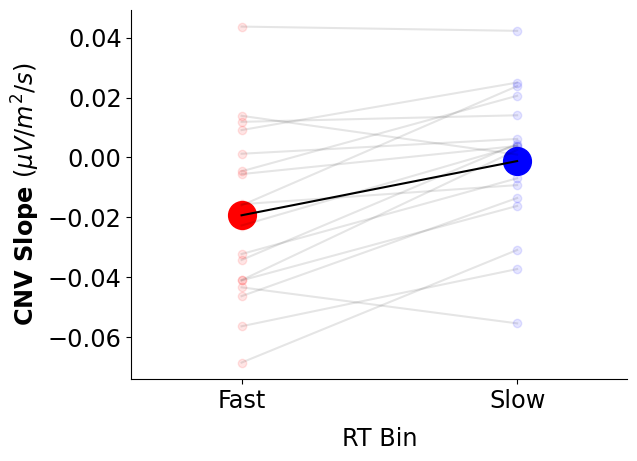

In [42]:
fig, ax = plt.subplots()
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(["Fast", "Slow"])

ax.plot(0.25, ANOVA_df["Fast"].mean(), marker = "o", markersize = "20", color = colors[0])
ax.plot(0.75, ANOVA_df["Slow"].mean(), marker = "o", markersize = "20", color = colors[1])
ax.plot(np.array([0.25, 0.75]), ANOVA_df.mean(axis = 0), color = "k")

for ID in ID_list:
  participant_df = ANOVA_df.loc[ID]
  ax.plot(0.25, participant_df["Fast"], marker = "o", alpha = 0.1, color = colors[0])
  ax.plot(0.75, participant_df["Slow"], marker = "o", alpha = 0.1, color = colors[1])
  ax.plot([0.25, 0.75], np.array(participant_df), alpha = 0.1, color = "k")

sns.despine()
plt.xlim(0.05, 0.95)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 10)
plt.ylabel("CNV Slope" + " " + "$(\mu V/m^2/s)$", fontsize = "xx-large", weight='bold')
ax = plt.gca()
ax.tick_params(labelsize = "xx-large")

fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/ERPs/" + "RL_CNV_Slope_RT_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

In [43]:
labels = ["Fast", "Slow"]
conds = [1, 2]

dv = "RL_CNV_Amp"

trial_numbers_RL = np.zeros((len(ID_list), len(conds)))

ANOVA_array = np.zeros((len(ID_list), len(labels)))

mean_RT = np.zeros((len(ID_list), len(conds)))

for i in range(0, len(ID_list)):
  participant_df = RL_metadata[RL_metadata["ID"] == ID_list[i]]

  for j in range(0, len(labels)):
    cond = conds[j]
    #condition_df = participant_df.query("RT_Bin2 == @cond")
    condition_df = participant_df[participant_df["RT_Bin2"] == cond]
    ANOVA_array[i, j] = condition_df[dv].mean()
    trial_numbers_RL[i, j] = condition_df.shape[0]
    mean_RT[i, j] = condition_df["Response_Time"].mean()

ANOVA_df = pd.DataFrame(ANOVA_array, columns = labels, index = ID_list)
ANOVA_df

,Fast,Slow
P1,-8.514700,-4.813533
P3,-42.891765,-33.778293
P4,-31.795069,-27.142663
P7,-37.351485,-31.123121
P10,-32.216896,-34.858832
P12,-12.712563,-3.616800
P15,-32.105832,-31.515743
P17,-24.975145,-19.054398
P19,-13.808330,-3.007949
P21,-27.224542,-10.401805


In [44]:
if stan:
  fname = "/content/gdrive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "RL_CNV_Amp_jasp_Med_ANOVA.csv"
  ANOVA_df.to_csv(fname)

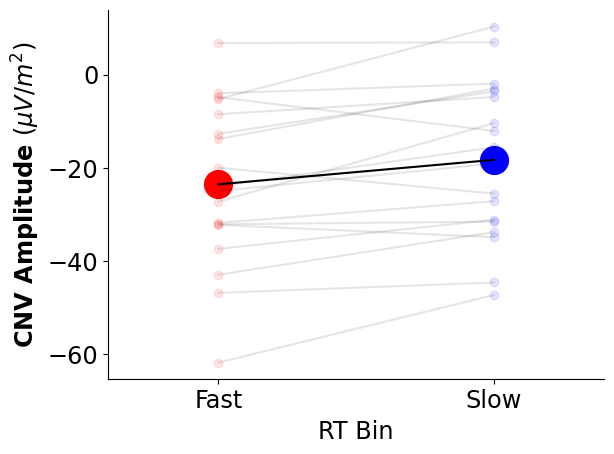

In [45]:
fig, ax = plt.subplots()
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(["Fast", "Slow"])

ax.plot(0.25, ANOVA_df["Fast"].mean(), marker = "o", markersize = "20", color = colors[0])
ax.plot(0.75, ANOVA_df["Slow"].mean(), marker = "o", markersize = "20", color = colors[1])
ax.plot(np.array([0.25, 0.75]), ANOVA_df.mean(axis = 0), color = "k")

for ID in ID_list:
  participant_df = ANOVA_df.loc[ID]
  ax.plot(0.25, participant_df["Fast"], marker = "o", alpha = 0.1, color = colors[0])
  ax.plot(0.75, participant_df["Slow"], marker = "o", alpha = 0.1, color = colors[1])
  ax.plot([0.25, 0.75], np.array(participant_df), alpha = 0.1, color = "k")

sns.despine()
plt.xlim(0.05, 0.95)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 5)
plt.ylabel("CNV Amplitude" + " " + "$(\mu V/m^2)$", fontsize = "xx-large", weight='bold')
ax = plt.gca()
ax.tick_params(labelsize = "xx-large")

fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/ERPs/" + "RL_CNV_Amp_RT_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

In [46]:
labels = ["Fast", "Slow"]
conds = [1, 2]

dv = "RL_CPP_Slope"

trial_numbers_RL = np.zeros((len(ID_list), len(conds)))

ANOVA_array = np.zeros((len(ID_list), len(labels)))

mean_RT = np.zeros((len(ID_list), len(conds)))

for i in range(0, len(ID_list)):
  participant_df = RL_metadata[RL_metadata["ID"] == ID_list[i]]

  for j in range(0, len(labels)):
    cond = conds[j]
    #condition_df = participant_df.query("RT_Bin2 == @cond")
    condition_df = participant_df[participant_df["RT_Bin2"] == cond]
    ANOVA_array[i, j] = condition_df[dv].mean()
    trial_numbers_RL[i, j] = condition_df.shape[0]
    mean_RT[i, j] = condition_df["Response_Time"].mean()

ANOVA_df = pd.DataFrame(ANOVA_array, columns = labels, index = ID_list)
ANOVA_df

,Fast,Slow
P1,-0.005365,-0.001615
P3,-0.010432,-0.029823
P4,0.008556,0.002869
P7,0.015018,0.020828
P10,-0.022943,-0.033779
P12,0.019757,0.038152
P15,-0.025437,-0.005760
P17,0.000017,0.013069
P19,0.020127,0.001194
P21,0.015045,0.026802


In [47]:
if stan:
  fname = "/content/gdrive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "RL_CPP_Slope_jasp_Med_ANOVA.csv"
  ANOVA_df.to_csv(fname)

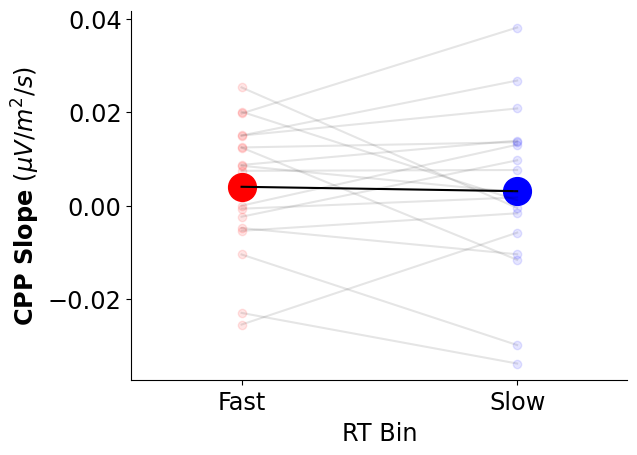

In [48]:
fig, ax = plt.subplots()
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(["Fast", "Slow"])

ax.plot(0.25, ANOVA_df["Fast"].mean(), marker = "o", markersize = "20", color = colors[0])
ax.plot(0.75, ANOVA_df["Slow"].mean(), marker = "o", markersize = "20", color = colors[1])
ax.plot(np.array([0.25, 0.75]), ANOVA_df.mean(axis = 0), color = "k")

for ID in ID_list:
  participant_df = ANOVA_df.loc[ID]
  ax.plot(0.25, participant_df["Fast"], marker = "o", alpha = 0.1, color = colors[0])
  ax.plot(0.75, participant_df["Slow"], marker = "o", alpha = 0.1, color = colors[1])
  ax.plot([0.25, 0.75], np.array(participant_df), alpha = 0.1, color = "k")

sns.despine()
plt.xlim(0.05, 0.95)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 5)
plt.ylabel("CPP Slope" + " " + "$(\mu V/m^2/s)$", fontsize = "xx-large", weight='bold')
ax = plt.gca()
ax.tick_params(labelsize = "xx-large")

fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/ERPs/" + "RL_CPP_Slope_RT_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

In [49]:
labels = ["Fast", "Slow"]
conds = [1, 2]

dv = "RL_CPP_Amp"

trial_numbers_RL = np.zeros((len(ID_list), len(conds)))

ANOVA_array = np.zeros((len(ID_list), len(labels)))

mean_RT = np.zeros((len(ID_list), len(conds)))

for i in range(0, len(ID_list)):
  participant_df = RL_metadata[RL_metadata["ID"] == ID_list[i]]

  for j in range(0, len(labels)):
    cond = conds[j]
    #condition_df = participant_df.query("RT_Bin2 == @cond")
    condition_df = participant_df[participant_df["RT_Bin2"] == cond]
    ANOVA_array[i, j] = condition_df[dv].mean()
    trial_numbers_RL[i, j] = condition_df.shape[0]
    mean_RT[i, j] = condition_df["Response_Time"].mean()

ANOVA_df = pd.DataFrame(ANOVA_array, columns = labels, index = ID_list)
ANOVA_df

,Fast,Slow
P1,23.264751,14.917754
P3,8.918272,0.745977
P4,1.880415,-3.649236
P7,9.367562,9.076628
P10,-4.848694,-10.282457
P12,-10.666554,-16.258740
P15,-34.763801,-27.202584
P17,-6.609527,7.844139
P19,16.300635,8.677411
P21,1.129809,3.563031


In [50]:
if stan:
  fname = "/content/gdrive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "RL_CPP_Amp_jasp_Med_ANOVA.csv"
  ANOVA_df.to_csv(fname)

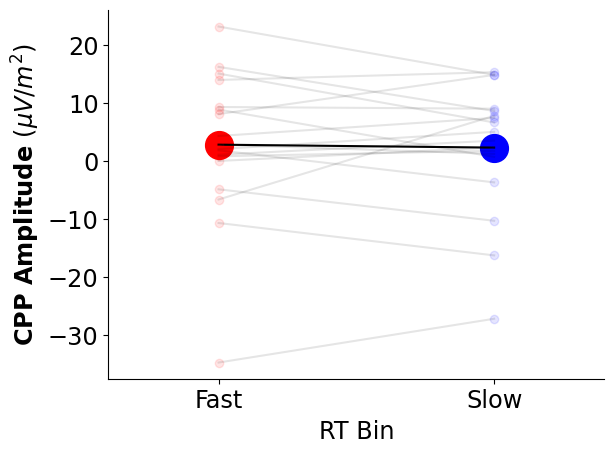

In [51]:
fig, ax = plt.subplots()
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(["Fast", "Slow"])

ax.plot(0.25, ANOVA_df["Fast"].mean(), marker = "o", markersize = "20", color = colors[0])
ax.plot(0.75, ANOVA_df["Slow"].mean(), marker = "o", markersize = "20", color = colors[1])
ax.plot(np.array([0.25, 0.75]), ANOVA_df.mean(axis = 0), color = "k")

for ID in ID_list:
  participant_df = ANOVA_df.loc[ID]
  ax.plot(0.25, participant_df["Fast"], marker = "o", alpha = 0.1, color = colors[0])
  ax.plot(0.75, participant_df["Slow"], marker = "o", alpha = 0.1, color = colors[1])
  ax.plot([0.25, 0.75], np.array(participant_df), alpha = 0.1, color = "k")

sns.despine()
plt.xlim(0.05, 0.95)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 5)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 5)
plt.ylabel("CPP Amplitude" + " " + "$(\mu V/m^2)$", fontsize = "xx-large", weight='bold')
ax = plt.gca()
ax.tick_params(labelsize = "xx-large")

fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/ERPs/" + "RL_CPP_Amp_RT_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

In [52]:
repo_metadata.head()

,ID,trial_number,Response_Time,Over_Under,Mean_RT,Median_RT,SI,Gap,Reject_Artif,RT_gap,Reject_All,Repo_Onset_CNV_Amp,Repo_Onset_CPP_Amp,RT_Bin2
0,P1,0,-0.270962,0.0,1026.308594,1013.867188,0.387298,-0.023678,0.0,1283.203125,0.0,-32.770791,66.968969,1.0
1,P1,4,0.047829,0.0,1013.515625,1011.914062,0.000000,0.104893,0.0,1351.562500,0.0,144.041320,39.757562,1.0
2,P1,5,-0.121529,0.0,945.742188,942.578125,-1.549193,0.104893,0.0,1318.359375,0.0,22.475720,47.928816,NaN
3,P1,6,-0.828846,0.0,980.234375,965.039062,-1.161895,-0.923679,0.0,1132.812500,0.0,-14.549461,-26.547333,1.0
4,P1,10,-0.370584,0.0,980.234375,965.039062,-1.161895,-0.323678,0.0,1250.000000,0.0,23.833309,-64.358109,1.0


In [53]:
labels = ["Fast", "Slow"]
conds = [1, 2]

dv = "Repo_Onset_CNV_Amp"

trial_numbers_RL = np.zeros((len(ID_list), len(conds)))

ANOVA_array = np.zeros((len(ID_list), len(labels)))

mean_RT = np.zeros((len(ID_list), len(conds)))

for i in range(0, len(ID_list)):
  participant_df = repo_metadata[repo_metadata["ID"] == ID_list[i]]

  for j in range(0, len(labels)):
    cond = conds[j]
    #condition_df = participant_df.query("RT_Bin2 == @cond")
    condition_df = participant_df[participant_df["RT_Bin2"] == cond]
    ANOVA_array[i, j] = condition_df[dv].mean()
    mean_RT[i, j] = condition_df["Response_Time"].mean()

ANOVA_df = pd.DataFrame(ANOVA_array, columns = labels, index = ID_list)
ANOVA_df

,Fast,Slow
P1,-11.385515,1.859364
P3,-11.110467,-7.695183
P4,-27.621584,-21.340738
P7,-14.811834,-11.648580
P10,-21.667611,-18.702423
P12,-5.084888,-1.275472
P15,-19.442680,-26.092828
P17,-54.189423,-44.235128
P19,-11.665177,1.859673
P21,-16.843215,-3.580423


In [54]:
if stan:
  fname = "/content/gdrive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "Repo_Onset_CNV_Amp_jasp_Med_ANOVA.csv"
  ANOVA_df.to_csv(fname)

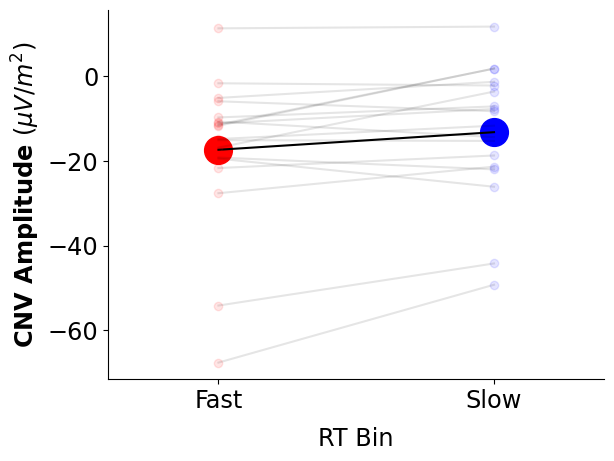

In [55]:
fig, ax = plt.subplots()
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(["Fast", "Slow"])

ax.plot(0.25, ANOVA_df["Fast"].mean(), marker = "o", markersize = "20", color = colors[0])
ax.plot(0.75, ANOVA_df["Slow"].mean(), marker = "o", markersize = "20", color = colors[1])
ax.plot(np.array([0.25, 0.75]), ANOVA_df.mean(axis = 0), color = "k")

for ID in ID_list:
  participant_df = ANOVA_df.loc[ID]
  ax.plot(0.25, participant_df["Fast"], marker = "o", alpha = 0.1, color = colors[0])
  ax.plot(0.75, participant_df["Slow"], marker = "o", alpha = 0.1, color = colors[1])
  ax.plot([0.25, 0.75], np.array(participant_df), alpha = 0.1, color = "k")

sns.despine()
plt.xlim(0.05, 0.95)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 5)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 10)
plt.ylabel("CNV Amplitude" + " " + "$(\mu V/m^2)$", fontsize = "xx-large", weight='bold')
ax = plt.gca()
ax.tick_params(labelsize = "xx-large")

fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/ERPs/" + "Cue_Onset_CNV_RT_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

In [56]:
labels = ["Fast", "Slow"]
conds = [1, 2]

dv = "Repo_Onset_CPP_Amp"

trial_numbers_RL = np.zeros((len(ID_list), len(conds)))

ANOVA_array = np.zeros((len(ID_list), len(labels)))

mean_RT = np.zeros((len(ID_list), len(conds)))

for i in range(0, len(ID_list)):
  participant_df = repo_metadata[repo_metadata["ID"] == ID_list[i]]

  for j in range(0, len(labels)):
    cond = conds[j]
    #condition_df = participant_df.query("RT_Bin2 == @cond")
    condition_df = participant_df[participant_df["RT_Bin2"] == cond]
    ANOVA_array[i, j] = condition_df[dv].mean()
    mean_RT[i, j] = condition_df["Response_Time"].mean()

ANOVA_df = pd.DataFrame(ANOVA_array, columns = labels, index = ID_list)
ANOVA_df

,Fast,Slow
P1,22.473823,13.467211
P3,9.853078,7.801209
P4,1.292152,-2.318512
P7,7.232753,0.741757
P10,-3.942681,0.236059
P12,-16.260366,-30.027859
P15,-29.421042,-19.243700
P17,-5.654401,-2.876422
P19,8.580658,3.532206
P21,1.798819,3.425176


In [57]:
if stan:
  fname = "/content/gdrive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "Repo_Onset_CPP_Amp_jasp_Med_ANOVA.csv"
  ANOVA_df.to_csv(fname)

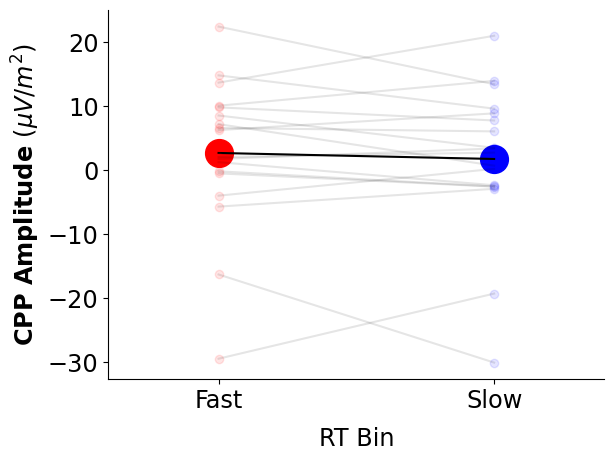

In [58]:
fig, ax = plt.subplots()
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(["Fast", "Slow"])

ax.plot(0.25, ANOVA_df["Fast"].mean(), marker = "o", markersize = "20", color = colors[0])
ax.plot(0.75, ANOVA_df["Slow"].mean(), marker = "o", markersize = "20", color = colors[1])
ax.plot(np.array([0.25, 0.75]), ANOVA_df.mean(axis = 0), color = "k")

for ID in ID_list:
  participant_df = ANOVA_df.loc[ID]
  ax.plot(0.25, participant_df["Fast"], marker = "o", alpha = 0.1, color = colors[0])
  ax.plot(0.75, participant_df["Slow"], marker = "o", alpha = 0.1, color = colors[1])
  ax.plot([0.25, 0.75], np.array(participant_df), alpha = 0.1, color = "k")

sns.despine()
plt.xlim(0.05, 0.95)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 5)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 10)
plt.ylabel("CPP Amplitude" + " " + "$(\mu V/m^2)$", fontsize = "xx-large", weight='bold')
ax = plt.gca()
ax.tick_params(labelsize = "xx-large")

fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/ERPs/" + "Cue_Onset_CPP_RT_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

In [59]:
labels = ["Fast", "Slow"]
conds = [1, 2]

dv = "Encode_Offset_CNV_Amp"

trial_numbers_encode = np.zeros((len(ID_list), len(conds)))

ANOVA_array = np.zeros((len(ID_list), len(labels)))

mean_RT = np.zeros((len(ID_list), len(conds)))

for i in range(0, len(ID_list)):
  participant_df = encode_metadata[encode_metadata["ID"] == ID_list[i]]

  for j in range(0, len(labels)):
    cond = conds[j]
    #condition_df = participant_df.query("RT_Bin2 == @cond")
    condition_df = participant_df[participant_df["RT_Bin2"] == cond]
    ANOVA_array[i, j] = condition_df[dv].mean()
    mean_RT[i, j] = condition_df["Response_Time"].mean()

ANOVA_df = pd.DataFrame(ANOVA_array, columns = labels, index = ID_list)
ANOVA_df

,Fast,Slow
P1,7.154653,9.438607
P3,-16.540485,-13.147474
P4,-10.014436,-5.692040
P7,-11.216235,-15.560189
P10,-15.847366,-16.040132
P12,-0.673315,1.344233
P15,-5.196259,-15.265684
P17,-41.066123,-35.263274
P19,-1.554140,3.341414
P21,-1.440018,7.659534


In [60]:
if stan:
  fname = "/content/gdrive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "Encode_Offset_CNV_Amp_jasp_Med_ANOVA.csv"
  ANOVA_df.to_csv(fname)

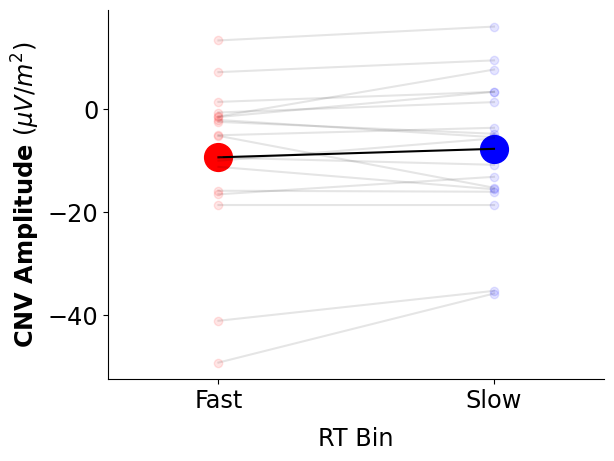

In [61]:
fig, ax = plt.subplots()
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(["Fast", "Slow"])

ax.plot(0.25, ANOVA_df["Fast"].mean(), marker = "o", markersize = "20", color = colors[0])
ax.plot(0.75, ANOVA_df["Slow"].mean(), marker = "o", markersize = "20", color = colors[1])
ax.plot(np.array([0.25, 0.75]), ANOVA_df.mean(axis = 0), color = "k")

for ID in ID_list:
  participant_df = ANOVA_df.loc[ID]
  ax.plot(0.25, participant_df["Fast"], marker = "o", alpha = 0.1, color = colors[0])
  ax.plot(0.75, participant_df["Slow"], marker = "o", alpha = 0.1, color = colors[1])
  ax.plot([0.25, 0.75], np.array(participant_df), alpha = 0.1, color = "k")

sns.despine()
plt.xlim(0.05, 0.95)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 5)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 10)
plt.ylabel("CNV Amplitude" + " " + "$(\mu V/m^2)$", fontsize = "xx-large", weight='bold')
ax = plt.gca()
ax.tick_params(labelsize = "xx-large")

fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/ERPs/" + "Encode_Offset_CNV_Amp_RT_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

In [62]:
labels = ["Fast", "Slow"]
conds = [1, 2]

dv = "Encode_Offset_CPP_Amp"

trial_numbers_encode = np.zeros((len(ID_list), len(conds)))

ANOVA_array = np.zeros((len(ID_list), len(labels)))

mean_RT = np.zeros((len(ID_list), len(conds)))

for i in range(0, len(ID_list)):
  participant_df = encode_metadata[encode_metadata["ID"] == ID_list[i]]

  for j in range(0, len(labels)):
    cond = conds[j]
    #condition_df = participant_df.query("RT_Bin2 == @cond")
    condition_df = participant_df[participant_df["RT_Bin2"] == cond]
    ANOVA_array[i, j] = condition_df[dv].mean()
    mean_RT[i, j] = condition_df["Response_Time"].mean()

ANOVA_df = pd.DataFrame(ANOVA_array, columns = labels, index = ID_list)
ANOVA_df

,Fast,Slow
P1,1.770577,-0.873358
P3,5.862261,3.594180
P4,-7.415502,-9.678777
P7,4.971596,-1.434270
P10,0.698000,-0.180933
P12,-15.430332,-22.926880
P15,-19.054409,-15.499197
P17,-7.327772,-7.841954
P19,5.086295,1.164993
P21,-0.270753,-1.051397


In [63]:
if stan:
  fname = "/content/gdrive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "Encode_Offset_CPP_Amp_jasp_Med_ANOVA.csv"
  ANOVA_df.to_csv(fname)

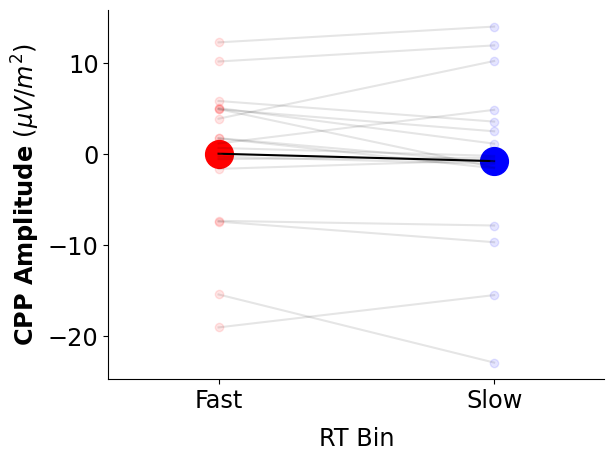

In [64]:
fig, ax = plt.subplots()
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(["Fast", "Slow"])

ax.plot(0.25, ANOVA_df["Fast"].mean(), marker = "o", markersize = "20", color = colors[0])
ax.plot(0.75, ANOVA_df["Slow"].mean(), marker = "o", markersize = "20", color = colors[1])
ax.plot(np.array([0.25, 0.75]), ANOVA_df.mean(axis = 0), color = "k")

for ID in ID_list:
  participant_df = ANOVA_df.loc[ID]
  ax.plot(0.25, participant_df["Fast"], marker = "o", alpha = 0.1, color = colors[0])
  ax.plot(0.75, participant_df["Slow"], marker = "o", alpha = 0.1, color = colors[1])
  ax.plot([0.25, 0.75], np.array(participant_df), alpha = 0.1, color = "k")

sns.despine()
plt.xlim(0.05, 0.95)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 5)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 10)
plt.ylabel("CPP Amplitude" + " " + "$(\mu V/m^2)$", fontsize = "xx-large", weight='bold')
ax = plt.gca()
ax.tick_params(labelsize = "xx-large")

fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/ERPs/" + "Encode_Offset_CPP_Amp_RT_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

In [65]:
labels = ["Fast", "Slow"]
conds = [1, 2]

dv = "Encode_Offset_CNV_Slope"

trial_numbers_encode = np.zeros((len(ID_list), len(conds)))

ANOVA_array = np.zeros((len(ID_list), len(labels)))

mean_RT = np.zeros((len(ID_list), len(conds)))

for i in range(0, len(ID_list)):
  participant_df = encode_metadata[encode_metadata["ID"] == ID_list[i]]

  for j in range(0, len(labels)):
    cond = conds[j]
    #condition_df = participant_df.query("RT_Bin2 == @cond")
    condition_df = participant_df[participant_df["RT_Bin2"] == cond]
    ANOVA_array[i, j] = condition_df[dv].mean()
    mean_RT[i, j] = condition_df["Response_Time"].mean()

ANOVA_df = pd.DataFrame(ANOVA_array, columns = labels, index = ID_list)
ANOVA_df

,Fast,Slow
P1,0.062638,0.008662
P3,0.012488,0.032416
P4,-0.001299,-0.011390
P7,0.015966,0.023566
P10,0.031492,0.004752
P12,0.069444,-0.011073
P15,0.002840,-0.002490
P17,0.000577,0.065954
P19,-0.017035,0.016679
P21,0.010426,0.031418


In [66]:
if stan:
  fname = "/content/gdrive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "Encode_Offset_CNV_Slope_jasp_Med_ANOVA.csv"
  ANOVA_df.to_csv(fname)

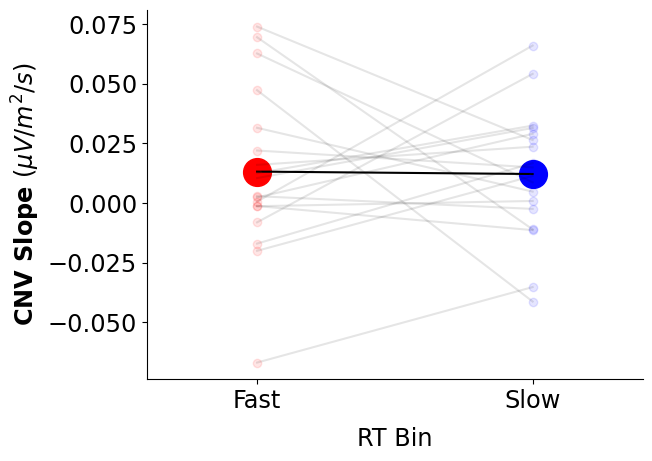

In [67]:
fig, ax = plt.subplots()
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(["Fast", "Slow"])

ax.plot(0.25, ANOVA_df["Fast"].mean(), marker = "o", markersize = "20", color = colors[0])
ax.plot(0.75, ANOVA_df["Slow"].mean(), marker = "o", markersize = "20", color = colors[1])
ax.plot(np.array([0.25, 0.75]), ANOVA_df.mean(axis = 0), color = "k")

for ID in ID_list:
  participant_df = ANOVA_df.loc[ID]
  ax.plot(0.25, participant_df["Fast"], marker = "o", alpha = 0.1, color = colors[0])
  ax.plot(0.75, participant_df["Slow"], marker = "o", alpha = 0.1, color = colors[1])
  ax.plot([0.25, 0.75], np.array(participant_df), alpha = 0.1, color = "k")

sns.despine()
plt.xlim(0.05, 0.95)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 5)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 10)
plt.ylabel("CNV Slope" + " " + "$(\mu V/m^2/s)$", fontsize = "xx-large", weight='bold')
ax = plt.gca()
ax.tick_params(labelsize = "xx-large")

fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/ERPs/" + "Encode_Offset_Slope_Amp_RT_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

In [68]:
labels = ["Fast", "Slow"]
conds = [1, 2]

dv = "Encode_Offset_CPP_Slope"

trial_numbers_encode = np.zeros((len(ID_list), len(conds)))

ANOVA_array = np.zeros((len(ID_list), len(labels)))

mean_RT = np.zeros((len(ID_list), len(conds)))

for i in range(0, len(ID_list)):
  participant_df = encode_metadata[encode_metadata["ID"] == ID_list[i]]

  for j in range(0, len(labels)):
    cond = conds[j]
    #condition_df = participant_df.query("RT_Bin2 == @cond")
    condition_df = participant_df[participant_df["RT_Bin2"] == cond]
    ANOVA_array[i, j] = condition_df[dv].mean()
    mean_RT[i, j] = condition_df["Response_Time"].mean()

ANOVA_df = pd.DataFrame(ANOVA_array, columns = labels, index = ID_list)
ANOVA_df

,Fast,Slow
P1,-0.005252,0.030811
P3,0.007464,0.018630
P4,-0.001819,0.001973
P7,0.005031,0.020500
P10,-0.018197,0.000817
P12,0.022973,-0.037112
P15,0.036543,0.013147
P17,-0.005778,0.007954
P19,0.010463,0.005828
P21,-0.053849,0.017946


In [69]:
if stan:
  fname = "/content/gdrive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "Encode_Offset_CPP_Slope_jasp_Med_ANOVA.csv"
  ANOVA_df.to_csv(fname)

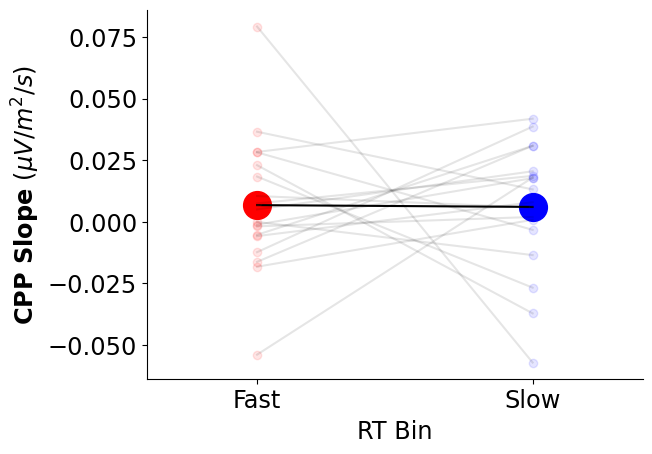

In [70]:
fig, ax = plt.subplots()
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(["Fast", "Slow"])

ax.plot(0.25, ANOVA_df["Fast"].mean(), marker = "o", markersize = "20", color = colors[0])
ax.plot(0.75, ANOVA_df["Slow"].mean(), marker = "o", markersize = "20", color = colors[1])
ax.plot(np.array([0.25, 0.75]), ANOVA_df.mean(axis = 0), color = "k")

for ID in ID_list:
  participant_df = ANOVA_df.loc[ID]
  ax.plot(0.25, participant_df["Fast"], marker = "o", alpha = 0.1, color = colors[0])
  ax.plot(0.75, participant_df["Slow"], marker = "o", alpha = 0.1, color = colors[1])
  ax.plot([0.25, 0.75], np.array(participant_df), alpha = 0.1, color = "k")

sns.despine()
plt.xlim(0.05, 0.95)
plt.xlabel("RT Bin", fontsize = "xx-large", labelpad = 5)
plt.ylabel("CPP Slope" + " " + "$(\mu V/m^2/s)$", fontsize = "xx-large", weight='bold')
ax = plt.gca()
ax.tick_params(labelsize = "xx-large")

fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/ERPs/" + "Encode_Offset_CPP_Slope_RT_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")